# Deep cortical reinforcement learning: Policy gradients + Q-learning + GAN


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.9948531410753465 -2.9585533161735422
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [13]:
# Data of the model
def model_input(state_size, lstm_size, batch_size=1):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    # GRU: Gated Recurrent Units
    gru = tf.nn.rnn_cell.GRUCell(lstm_size) # hidden size
    cell = tf.nn.rnn_cell.MultiRNNCell([gru], state_is_tuple=False)
    g_initial_state = cell.zero_state(batch_size, tf.float32) # feedback or lateral/recurrent connection from output
    d_initial_state = cell.zero_state(batch_size, tf.float32) # feedback or lateral/recurrent connection from output
    return states, actions, targetQs, cell, g_initial_state, d_initial_state

In [14]:
# How to use batch-norm
#   x_norm = tf.layers.batch_normalization(x, training=training)

#   # ...

#   update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#   with tf.control_dependencies(update_ops):
#     train_op = optimizer.minimize(loss)

In [15]:
# training: Either a Python boolean, or a TensorFlow boolean scalar tensor (e.g. a placeholder). 
# Whether to return the output in: 
# training mode (normalized with statistics of the current batch) or 
# inference mode (normalized with moving statistics). 
# NOTE: make sure to set this parameter correctly, or else your training/inference will not work properly.

In [16]:
# MLP & Conv
# # Generator/Controller: Generating/prediting the actions
# def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
#     with tf.variable_scope('generator', reuse=reuse):
#         # First fully connected layer
#         h1 = tf.layers.dense(inputs=states, units=hidden_size)
#         bn1 = tf.layers.batch_normalization(h1, training=training)        
#         nl1 = tf.maximum(alpha * bn1, bn1)
        
#         # Second fully connected layer
#         h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
#         bn2 = tf.layers.batch_normalization(h2, training=training)        
#         nl2 = tf.maximum(alpha * bn2, bn2)
        
#         # Output layer
#         logits = tf.layers.dense(inputs=nl2, units=action_size)        
#         #predictions = tf.nn.softmax(logits)

#         # return actions logits
#         return logits

In [17]:
# RNN generator or sequence generator
def generator(states, initial_state, cell, lstm_size, num_classes, reuse=False): 
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        inputs = tf.layers.dense(inputs=states, units=lstm_size)
        print(states.shape, inputs.shape)
        
        # with tf.variable_scope('dynamic_rnn_', reuse=tf.AUTO_REUSE):
        # dynamic means adapt to the batch_size
        inputs_rnn = tf.reshape(inputs, [1, -1, lstm_size]) # NxH -> 1xNxH
        print(inputs_rnn.shape, initial_state.shape)
        outputs_rnn, final_state = tf.nn.dynamic_rnn(cell=cell, inputs=inputs_rnn, initial_state=initial_state)
        print(outputs_rnn.shape, final_state.shape)
        outputs = tf.reshape(outputs_rnn, [-1, lstm_size]) # 1xNxH -> NxH
        print(outputs.shape)

        # Last fully connected layer
        logits = tf.layers.dense(inputs=outputs, units=num_classes)
        print(logits.shape)
        #predictions = tf.nn.softmax(logits)
        
        # logits are the action logits
        return logits, final_state

In [18]:
# MLP & Conv
# # Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
# def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
#     with tf.variable_scope('discriminator', reuse=reuse):
#         # Fusion/merge states and actions/ SA/ SM
#         x_fused = tf.concat(axis=1, values=[states, actions])
        
#         # First fully connected layer
#         h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
#         bn1 = tf.layers.batch_normalization(h1, training=training)        
#         nl1 = tf.maximum(alpha * bn1, bn1)
        
#         # Second fully connected layer
#         h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
#         bn2 = tf.layers.batch_normalization(h2, training=training)        
#         nl2 = tf.maximum(alpha * bn2, bn2)
        
#         # Output layer
#         logits = tf.layers.dense(inputs=nl2, units=1)        
#         #predictions = tf.nn.softmax(logits)

#         # return rewards logits
#         return logits

In [19]:
# RNN generator or sequence generator
def discriminator(states, actions, initial_state, cell, lstm_size, reuse=False): 
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        inputs = tf.layers.dense(inputs=x_fused, units=lstm_size)
        print(states.shape, inputs.shape)
        
        # with tf.variable_scope('dynamic_rnn_', reuse=tf.AUTO_REUSE):
        inputs_rnn = tf.reshape(inputs, [1, -1, lstm_size]) # NxH -> 1xNxH
        print(inputs_rnn.shape, initial_state.shape)
        outputs_rnn, final_state = tf.nn.dynamic_rnn(cell=cell, inputs=inputs_rnn, initial_state=initial_state)
        print(outputs_rnn.shape, final_state.shape)
        outputs = tf.reshape(outputs_rnn, [-1, lstm_size]) # 1xNxH -> NxH
        print(outputs.shape)

        # Last fully connected layer
        logits = tf.layers.dense(inputs=outputs, units=1)
        print(logits.shape)
        #predictions = tf.nn.softmax(logits)
        
        # logits are the action logits
        return logits, final_state

In [20]:
def model_loss(action_size, hidden_size, states, actions, targetQs,
               cell, g_initial_state, d_initial_state):
    # G/Actor
    #actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_logits, g_final_state = generator(states=states, num_classes=action_size, 
                                              cell=cell, initial_state=g_initial_state, lstm_size=hidden_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    g_loss = tf.reduce_mean(neg_log_prob_actions * targetQs)
    
    # D/Critic
    #Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    Qs, d_final_state = discriminator(states=states, actions=actions_logits, 
                                      cell=cell, initial_state=d_initial_state, lstm_size=hidden_size)
    d_loss = tf.reduce_mean(tf.square(Qs - targetQs))

    return actions_logits, Qs, g_final_state, d_final_state, g_loss, d_loss

In [21]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize RNN
    # g_grads, _ = tf.clip_by_global_norm(t_list=tf.gradients(g_loss, g_vars), clip_norm=5) # usually around 1-5
    # d_grads, _ = tf.clip_by_global_norm(t_list=tf.gradients(d_loss, d_vars), clip_norm=5) # usually around 1-5
    g_grads=tf.gradients(g_loss, g_vars)
    d_grads=tf.gradients(d_loss, d_vars)
    g_opt = tf.train.AdamOptimizer(learning_rate).apply_gradients(grads_and_vars=zip(g_grads, g_vars))
    d_opt = tf.train.AdamOptimizer(learning_rate).apply_gradients(grads_and_vars=zip(d_grads, d_vars))
    
    # # Optimize MLP & CNN
    # with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
    #     g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
    #     d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [22]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, cell, self.g_initial_state, self.d_initial_state = model_input(
            state_size=state_size, lstm_size=hidden_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_final_state, self.d_final_state, self.g_loss, self.d_loss = model_loss(
            action_size=action_size, hidden_size=hidden_size,
            states=self.states, actions=self.actions, cell=cell, targetQs=self.targetQs,
            g_initial_state=self.g_initial_state, d_initial_state=self.d_initial_state)
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

In [27]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
        self.states = deque(maxlen=max_size)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [28]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(1111, 4) actions:(1111,)
action size:2


In [41]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
# state_size = 37
# state_size_ = (84, 84, 3)
action_size = 2
hidden_size = 64             # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
gamma = 0.99                   # future reward discount
memory_size = 64            # memory capacity
batch_size = 64            # experience mini-batch size
# memory_size = 10000            # memory capacity
# batch_size = 200 # 20 original                # experience mini-batch size
# memory_size = 1000               # memory capacity
# batch_size = 1000                # experience mini-batch size

# Tested one
# # Training parameters
# # Network parameters
# state_size = 4                 # number of units for the input state/observation -- simulation
# action_size = 2                # number of units for the output actions -- simulation
# hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
# batch_size = 64                # number of samples in the memory/ experience as mini-batch size
# learning_rate = 0.001          # learning rate for adam

In [42]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

(?, 4) (?, 64)
(1, ?, 64) (1, 64)
(1, ?, 64) (1, 64)
(?, 64)
(?, 2)
(?, 4) (?, 64)
(1, ?, 64) (1, 64)
(1, ?, 64) (1, 64)
(?, 64)
(?, 1)


In [44]:
state = env.reset()
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    state = next_state
    if done is True:
        state = env.reset()

In [45]:
memory.buffer[0]

[array([ 0.00616049, -0.02409982,  0.01575451, -0.01139917]),
 0,
 array([ 0.00567849, -0.21944413,  0.01552653,  0.28621256]),
 1.0,
 0.0]

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
saver = tf.train.Saver()
episode_rewards_list, rewards_list, g_loss_list, d_loss_list = [], [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
    total_step = 0 # Explore or exploit parameter
    
    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0
        state = env.reset() # env first state
        g_initial_state = sess.run(model.g_initial_state)
        d_initial_state = sess.run(model.d_initial_state)

        # Training steps/batches
        while True:
            # Testing/inference
            action_logits, g_final_state, d_final_state = sess.run(
                fetches=[model.actions_logits, model.g_final_state, model.d_final_state], 
                feed_dict={model.states: np.reshape(state, [1, -1]),
                           model.g_initial_state: g_initial_state,
                           model.d_initial_state: d_initial_state})
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.states.append([g_initial_state, g_final_state,
                                  d_initial_state, d_final_state])
            total_reward += reward
            g_initial_state = g_final_state
            d_initial_state = d_final_state
            state = next_state
            
            # Training
            batch = memory.buffer
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            rnn_states = memory.states
            g_initial_states = np.array([each[0] for each in rnn_states])
            g_final_states = np.array([each[1] for each in rnn_states])
            d_initial_states = np.array([each[2] for each in rnn_states])
            d_final_states = np.array([each[3] for each in rnn_states])
            nextQs_logits = sess.run(fetches = model.Qs_logits,
                                     feed_dict = {model.states: next_states, 
                                                  model.g_initial_state: g_final_states[0].reshape([1, -1]),
                                                  model.d_initial_state: d_final_states[0].reshape([1, -1])})
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # exploit
            targetQs = rewards + (gamma * nextQs)
            g_loss, d_loss, _, _ = sess.run(fetches=[model.g_loss, model.d_loss, model.g_opt, model.d_opt],
                                            feed_dict = {model.states: states, 
                                                         model.actions: actions,
                                                         model.targetQs: targetQs,
                                    model.g_initial_state: g_initial_states[0].reshape([1, -1]),
                                    model.d_initial_state: d_initial_states[0].reshape([1, -1])})
            if done is True:
                break

        # Episode total reward and success rate/prob
        episode_reward.append(total_reward) # stopping criteria
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss))
        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        # Break episode/epoch loop
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model-seq.ckpt')

Episode:0 meanR:25.0000 R:25.0000 gloss:0.6974 dloss:1.0511
Episode:1 meanR:22.0000 R:19.0000 gloss:0.7606 dloss:1.0792
Episode:2 meanR:19.3333 R:14.0000 gloss:0.7919 dloss:1.0472
Episode:3 meanR:20.0000 R:22.0000 gloss:0.7184 dloss:1.1265
Episode:4 meanR:26.2000 R:51.0000 gloss:0.7423 dloss:1.0271
Episode:5 meanR:23.8333 R:12.0000 gloss:0.7800 dloss:1.0330
Episode:6 meanR:22.8571 R:17.0000 gloss:0.7630 dloss:1.0103
Episode:7 meanR:22.2500 R:18.0000 gloss:0.8216 dloss:1.0063
Episode:8 meanR:22.0000 R:20.0000 gloss:0.7926 dloss:1.0036
Episode:9 meanR:21.2000 R:14.0000 gloss:0.8035 dloss:1.0106
Episode:10 meanR:20.5455 R:14.0000 gloss:0.7867 dloss:1.0091
Episode:11 meanR:20.5000 R:20.0000 gloss:0.8088 dloss:0.9972
Episode:12 meanR:20.1538 R:16.0000 gloss:0.7975 dloss:0.9766
Episode:13 meanR:19.7143 R:14.0000 gloss:0.8278 dloss:0.9753
Episode:14 meanR:19.6667 R:19.0000 gloss:0.8945 dloss:0.9681
Episode:15 meanR:19.5000 R:17.0000 gloss:0.8848 dloss:1.0000
Episode:16 meanR:19.2353 R:15.0000

Episode:134 meanR:25.9200 R:18.0000 gloss:8.5385 dloss:9.4730
Episode:135 meanR:26.4300 R:63.0000 gloss:8.6666 dloss:5.4377
Episode:136 meanR:26.5600 R:27.0000 gloss:8.8348 dloss:5.5264
Episode:137 meanR:27.0800 R:67.0000 gloss:8.8388 dloss:6.8548
Episode:138 meanR:27.2900 R:51.0000 gloss:9.3710 dloss:6.3953
Episode:139 meanR:27.4300 R:46.0000 gloss:9.6824 dloss:6.6423
Episode:140 meanR:27.1600 R:21.0000 gloss:9.7762 dloss:11.5148
Episode:141 meanR:27.3200 R:47.0000 gloss:9.7931 dloss:10.2480
Episode:142 meanR:27.4800 R:29.0000 gloss:10.5660 dloss:7.3928
Episode:143 meanR:27.4000 R:15.0000 gloss:11.0900 dloss:10.6475
Episode:144 meanR:27.7100 R:52.0000 gloss:10.7278 dloss:11.7008
Episode:145 meanR:28.0300 R:43.0000 gloss:10.5745 dloss:7.7702
Episode:146 meanR:28.4600 R:54.0000 gloss:10.2543 dloss:8.0590
Episode:147 meanR:28.6700 R:39.0000 gloss:10.3092 dloss:8.1250
Episode:148 meanR:28.6100 R:25.0000 gloss:10.6538 dloss:24.1044
Episode:149 meanR:28.7500 R:56.0000 gloss:12.3995 dloss:8.

Episode:263 meanR:35.5300 R:27.0000 gloss:13.4698 dloss:21.2608
Episode:264 meanR:35.5900 R:33.0000 gloss:13.9820 dloss:21.4773
Episode:265 meanR:35.5200 R:26.0000 gloss:12.3239 dloss:21.4994
Episode:266 meanR:35.4700 R:26.0000 gloss:11.5741 dloss:22.0575
Episode:267 meanR:35.2400 R:24.0000 gloss:11.5699 dloss:21.8300
Episode:268 meanR:35.7300 R:58.0000 gloss:15.0953 dloss:15.0558
Episode:269 meanR:35.9900 R:43.0000 gloss:12.2795 dloss:16.4688
Episode:270 meanR:36.9600 R:112.0000 gloss:17.9639 dloss:9.7483
Episode:271 meanR:36.7800 R:15.0000 gloss:17.8123 dloss:18.8585
Episode:272 meanR:36.6700 R:37.0000 gloss:15.7040 dloss:29.0870
Episode:273 meanR:36.7000 R:31.0000 gloss:14.7012 dloss:22.1750
Episode:274 meanR:36.7500 R:32.0000 gloss:15.2613 dloss:29.5867
Episode:275 meanR:36.8300 R:38.0000 gloss:13.0342 dloss:19.9703
Episode:276 meanR:36.8600 R:43.0000 gloss:14.0869 dloss:19.0751
Episode:277 meanR:37.1700 R:50.0000 gloss:13.1680 dloss:18.9498
Episode:278 meanR:37.3300 R:34.0000 glos

Episode:392 meanR:27.8200 R:33.0000 gloss:9.7066 dloss:14.0600
Episode:393 meanR:28.0500 R:43.0000 gloss:9.5778 dloss:14.2797
Episode:394 meanR:28.1700 R:45.0000 gloss:10.0599 dloss:14.9072
Episode:395 meanR:28.2400 R:32.0000 gloss:9.5649 dloss:15.3993
Episode:396 meanR:28.1100 R:29.0000 gloss:9.8810 dloss:22.7367
Episode:397 meanR:28.3800 R:44.0000 gloss:9.7429 dloss:15.7773
Episode:398 meanR:28.3900 R:32.0000 gloss:11.0692 dloss:16.0287
Episode:399 meanR:28.5000 R:38.0000 gloss:9.8150 dloss:15.9050
Episode:400 meanR:28.5000 R:24.0000 gloss:8.9635 dloss:22.9402
Episode:401 meanR:28.5400 R:37.0000 gloss:8.5004 dloss:23.1002
Episode:402 meanR:28.6000 R:35.0000 gloss:6.7411 dloss:15.8416
Episode:403 meanR:28.6700 R:29.0000 gloss:8.5071 dloss:29.3884
Episode:404 meanR:28.6500 R:24.0000 gloss:11.9521 dloss:23.6821
Episode:405 meanR:28.4900 R:26.0000 gloss:11.3957 dloss:22.7288
Episode:406 meanR:28.5700 R:36.0000 gloss:12.6844 dloss:21.4324
Episode:407 meanR:28.6400 R:34.0000 gloss:9.0008 d

Episode:522 meanR:26.5300 R:24.0000 gloss:13.0644 dloss:18.0339
Episode:523 meanR:26.5200 R:21.0000 gloss:11.2237 dloss:17.6283
Episode:524 meanR:26.6600 R:40.0000 gloss:8.6166 dloss:17.2034
Episode:525 meanR:26.6700 R:22.0000 gloss:7.6016 dloss:17.7586
Episode:526 meanR:26.7100 R:20.0000 gloss:7.8017 dloss:18.1378
Episode:527 meanR:26.6400 R:30.0000 gloss:8.2465 dloss:18.1775
Episode:528 meanR:26.7500 R:31.0000 gloss:8.9087 dloss:17.9835
Episode:529 meanR:26.9000 R:39.0000 gloss:9.8613 dloss:12.7320
Episode:530 meanR:26.8500 R:25.0000 gloss:7.9866 dloss:21.9571
Episode:531 meanR:26.8800 R:33.0000 gloss:5.2908 dloss:19.2511
Episode:532 meanR:27.0100 R:37.0000 gloss:4.7499 dloss:13.4918
Episode:533 meanR:27.0700 R:33.0000 gloss:3.8424 dloss:13.7967
Episode:534 meanR:26.9700 R:17.0000 gloss:7.3952 dloss:20.4453
Episode:535 meanR:26.9400 R:29.0000 gloss:8.1547 dloss:19.4845
Episode:536 meanR:26.9000 R:29.0000 gloss:8.8219 dloss:19.6263
Episode:537 meanR:26.9400 R:23.0000 gloss:7.5844 dlos

Episode:652 meanR:27.9300 R:23.0000 gloss:8.1215 dloss:18.1498
Episode:653 meanR:27.9200 R:31.0000 gloss:7.9996 dloss:18.0388
Episode:654 meanR:28.0100 R:37.0000 gloss:5.9223 dloss:12.2758
Episode:655 meanR:27.9600 R:22.0000 gloss:5.2309 dloss:17.5845
Episode:656 meanR:27.9800 R:24.0000 gloss:5.8920 dloss:18.0187
Episode:657 meanR:27.8800 R:23.0000 gloss:5.1321 dloss:17.4642
Episode:658 meanR:27.8700 R:27.0000 gloss:4.9292 dloss:16.8175
Episode:659 meanR:27.8400 R:23.0000 gloss:3.4021 dloss:16.2009
Episode:660 meanR:27.9000 R:35.0000 gloss:3.9782 dloss:16.5838
Episode:661 meanR:27.6500 R:18.0000 gloss:4.8190 dloss:16.8409
Episode:662 meanR:27.7000 R:31.0000 gloss:5.7095 dloss:16.8174
Episode:663 meanR:27.9000 R:41.0000 gloss:4.0732 dloss:11.6543
Episode:664 meanR:28.0100 R:35.0000 gloss:2.8432 dloss:12.1705
Episode:665 meanR:27.9600 R:18.0000 gloss:2.6740 dloss:18.1164
Episode:666 meanR:28.1100 R:31.0000 gloss:5.4870 dloss:18.1758
Episode:667 meanR:28.3100 R:39.0000 gloss:6.3605 dloss:

Episode:783 meanR:28.9600 R:32.0000 gloss:6.0184 dloss:17.5708
Episode:784 meanR:28.9200 R:25.0000 gloss:4.5527 dloss:18.1537
Episode:785 meanR:28.9100 R:29.0000 gloss:6.2131 dloss:19.1704
Episode:786 meanR:28.7400 R:24.0000 gloss:4.6538 dloss:19.3927
Episode:787 meanR:28.8000 R:35.0000 gloss:1.5634 dloss:18.9366
Episode:788 meanR:28.8500 R:22.0000 gloss:3.7057 dloss:18.4934
Episode:789 meanR:28.8000 R:30.0000 gloss:9.3591 dloss:18.2458
Episode:790 meanR:28.9300 R:39.0000 gloss:11.7073 dloss:12.3655
Episode:791 meanR:29.0500 R:43.0000 gloss:5.8238 dloss:13.6370
Episode:792 meanR:29.2100 R:32.0000 gloss:4.3787 dloss:14.1165
Episode:793 meanR:29.2900 R:35.0000 gloss:4.4926 dloss:15.7509
Episode:794 meanR:29.2900 R:24.0000 gloss:5.9741 dloss:22.0530
Episode:795 meanR:29.3700 R:33.0000 gloss:6.3425 dloss:21.4615
Episode:796 meanR:29.6200 R:47.0000 gloss:5.7416 dloss:15.6121
Episode:797 meanR:29.6000 R:21.0000 gloss:8.7292 dloss:16.3209
Episode:798 meanR:29.6800 R:24.0000 gloss:7.2802 dloss

Episode:914 meanR:28.5900 R:28.0000 gloss:6.7762 dloss:17.4825
Episode:915 meanR:28.5300 R:26.0000 gloss:5.4451 dloss:17.2985
Episode:916 meanR:28.5200 R:24.0000 gloss:2.4507 dloss:17.3048
Episode:917 meanR:28.5700 R:46.0000 gloss:3.5217 dloss:12.1718
Episode:918 meanR:28.6900 R:29.0000 gloss:3.4809 dloss:13.1779
Episode:919 meanR:28.6800 R:26.0000 gloss:2.3889 dloss:18.8145
Episode:920 meanR:28.8200 R:40.0000 gloss:3.2008 dloss:13.8227
Episode:921 meanR:28.9100 R:27.0000 gloss:4.0998 dloss:13.8277
Episode:922 meanR:28.9200 R:21.0000 gloss:5.4199 dloss:19.2505
Episode:923 meanR:29.0400 R:34.0000 gloss:6.7136 dloss:17.5674
Episode:924 meanR:29.1200 R:32.0000 gloss:4.0407 dloss:12.5484
Episode:925 meanR:29.0600 R:25.0000 gloss:2.9015 dloss:17.3909
Episode:926 meanR:29.0800 R:30.0000 gloss:3.3396 dloss:17.3030
Episode:927 meanR:29.0700 R:27.0000 gloss:2.5298 dloss:16.9885
Episode:928 meanR:29.2800 R:40.0000 gloss:4.2066 dloss:12.0804
Episode:929 meanR:29.4300 R:36.0000 gloss:5.5133 dloss:

Episode:1044 meanR:36.0400 R:68.0000 gloss:1.4193 dloss:13.0592
Episode:1045 meanR:36.1000 R:34.0000 gloss:1.0142 dloss:23.4237
Episode:1046 meanR:36.1100 R:28.0000 gloss:0.8213 dloss:33.4239
Episode:1047 meanR:36.1400 R:34.0000 gloss:2.6979 dloss:31.4242
Episode:1048 meanR:36.0500 R:31.0000 gloss:3.2292 dloss:25.3954
Episode:1049 meanR:36.1400 R:33.0000 gloss:2.8980 dloss:29.9753
Episode:1050 meanR:36.1500 R:36.0000 gloss:4.5693 dloss:19.6670
Episode:1051 meanR:36.2100 R:33.0000 gloss:2.5243 dloss:19.5471
Episode:1052 meanR:36.0500 R:30.0000 gloss:2.1402 dloss:28.2438
Episode:1053 meanR:35.9900 R:37.0000 gloss:3.1045 dloss:19.1739
Episode:1054 meanR:35.9600 R:29.0000 gloss:4.3549 dloss:19.6855
Episode:1055 meanR:36.1300 R:37.0000 gloss:3.1208 dloss:19.5204
Episode:1056 meanR:36.1500 R:25.0000 gloss:2.2166 dloss:26.2479
Episode:1057 meanR:36.0700 R:40.0000 gloss:2.0929 dloss:19.9073
Episode:1058 meanR:36.0000 R:35.0000 gloss:5.7533 dloss:17.3989
Episode:1059 meanR:36.1100 R:35.0000 glo

Episode:1173 meanR:38.0700 R:55.0000 gloss:4.1893 dloss:20.8177
Episode:1174 meanR:38.0500 R:28.0000 gloss:7.2780 dloss:21.6439
Episode:1175 meanR:38.2600 R:40.0000 gloss:4.5628 dloss:20.1980
Episode:1176 meanR:38.3200 R:44.0000 gloss:1.0625 dloss:21.0379
Episode:1177 meanR:38.1900 R:31.0000 gloss:0.8256 dloss:20.9795
Episode:1178 meanR:38.1700 R:30.0000 gloss:3.7526 dloss:30.2853
Episode:1179 meanR:38.1800 R:44.0000 gloss:4.1964 dloss:20.0884
Episode:1180 meanR:37.9100 R:41.0000 gloss:4.3883 dloss:20.7214
Episode:1181 meanR:37.7900 R:32.0000 gloss:5.8616 dloss:21.2762
Episode:1182 meanR:37.7900 R:35.0000 gloss:2.7058 dloss:20.5192
Episode:1183 meanR:37.7000 R:35.0000 gloss:2.7640 dloss:19.3804
Episode:1184 meanR:37.8300 R:56.0000 gloss:6.8136 dloss:20.5088
Episode:1185 meanR:37.9100 R:35.0000 gloss:5.5856 dloss:21.2971
Episode:1186 meanR:37.9000 R:40.0000 gloss:4.7400 dloss:20.5038
Episode:1187 meanR:37.8400 R:25.0000 gloss:5.8775 dloss:23.6694
Episode:1188 meanR:37.9000 R:35.0000 glo

Episode:1301 meanR:42.3900 R:40.0000 gloss:2.9687 dloss:22.5636
Episode:1302 meanR:42.3700 R:32.0000 gloss:2.6274 dloss:23.1037
Episode:1303 meanR:42.5600 R:51.0000 gloss:0.3968 dloss:22.9768
Episode:1304 meanR:42.6500 R:37.0000 gloss:2.2527 dloss:23.2777
Episode:1305 meanR:42.7500 R:48.0000 gloss:0.8967 dloss:23.7278
Episode:1306 meanR:42.8400 R:47.0000 gloss:2.3519 dloss:23.7837
Episode:1307 meanR:42.7900 R:47.0000 gloss:1.7543 dloss:24.6164
Episode:1308 meanR:42.7500 R:33.0000 gloss:0.4217 dloss:25.3395
Episode:1309 meanR:42.9600 R:52.0000 gloss:0.3302 dloss:24.2539
Episode:1310 meanR:43.0800 R:44.0000 gloss:2.9877 dloss:25.2950
Episode:1311 meanR:42.9600 R:32.0000 gloss:0.4212 dloss:25.0912
Episode:1312 meanR:42.8900 R:32.0000 gloss:0.7044 dloss:32.1621
Episode:1313 meanR:43.4600 R:85.0000 gloss:0.9407 dloss:14.4200
Episode:1314 meanR:43.3600 R:30.0000 gloss:0.9083 dloss:27.9398
Episode:1315 meanR:43.2000 R:25.0000 gloss:0.8828 dloss:39.1132
Episode:1316 meanR:43.2600 R:39.0000 glo

Episode:1429 meanR:42.8400 R:35.0000 gloss:0.2071 dloss:23.0652
Episode:1430 meanR:43.0500 R:49.0000 gloss:0.2110 dloss:23.4031
Episode:1431 meanR:43.1300 R:35.0000 gloss:0.4186 dloss:24.1761
Episode:1432 meanR:43.1800 R:36.0000 gloss:0.4443 dloss:23.6766
Episode:1433 meanR:43.1600 R:44.0000 gloss:0.2715 dloss:23.0770
Episode:1434 meanR:42.8700 R:30.0000 gloss:0.3471 dloss:23.3894
Episode:1435 meanR:42.9000 R:34.0000 gloss:0.5911 dloss:30.4479
Episode:1436 meanR:42.7600 R:34.0000 gloss:0.5207 dloss:22.9007
Episode:1437 meanR:43.0200 R:57.0000 gloss:0.2240 dloss:23.4142
Episode:1438 meanR:42.9600 R:39.0000 gloss:3.0733 dloss:24.5264
Episode:1439 meanR:42.9600 R:36.0000 gloss:3.0332 dloss:23.7781
Episode:1440 meanR:42.9400 R:47.0000 gloss:0.4061 dloss:24.3004
Episode:1441 meanR:42.9600 R:41.0000 gloss:0.1920 dloss:24.5219
Episode:1442 meanR:42.8800 R:45.0000 gloss:2.8586 dloss:23.9709
Episode:1443 meanR:42.9800 R:45.0000 gloss:0.3326 dloss:24.2865
Episode:1444 meanR:43.0000 R:36.0000 glo

Episode:1557 meanR:41.6500 R:28.0000 gloss:0.3973 dloss:24.9365
Episode:1558 meanR:40.2800 R:40.0000 gloss:0.9182 dloss:23.9609
Episode:1559 meanR:40.3000 R:46.0000 gloss:2.4926 dloss:24.4787
Episode:1560 meanR:40.3200 R:31.0000 gloss:1.4278 dloss:24.0723
Episode:1561 meanR:40.2700 R:29.0000 gloss:4.8294 dloss:33.7184
Episode:1562 meanR:40.2300 R:28.0000 gloss:4.2476 dloss:32.6701
Episode:1563 meanR:41.2100 R:130.0000 gloss:1.2367 dloss:15.8347
Episode:1564 meanR:41.2400 R:45.0000 gloss:6.4350 dloss:30.3387
Episode:1565 meanR:42.1000 R:118.0000 gloss:3.1042 dloss:17.8508
Episode:1566 meanR:41.3100 R:47.0000 gloss:0.5938 dloss:34.5490
Episode:1567 meanR:40.7400 R:39.0000 gloss:0.4415 dloss:30.2641
Episode:1568 meanR:40.7900 R:33.0000 gloss:0.3951 dloss:29.0688
Episode:1569 meanR:40.7500 R:30.0000 gloss:0.2470 dloss:40.7892
Episode:1570 meanR:40.8100 R:34.0000 gloss:0.4022 dloss:34.5644
Episode:1571 meanR:40.6600 R:28.0000 gloss:1.0073 dloss:36.9916
Episode:1572 meanR:40.7100 R:41.0000 g

Episode:1685 meanR:45.7700 R:50.0000 gloss:7.9029 dloss:37.0709
Episode:1686 meanR:45.8100 R:42.0000 gloss:3.9964 dloss:30.6747
Episode:1687 meanR:45.8300 R:44.0000 gloss:6.7397 dloss:29.9393
Episode:1688 meanR:45.9200 R:40.0000 gloss:3.6017 dloss:31.0295
Episode:1689 meanR:46.9400 R:141.0000 gloss:0.6503 dloss:19.6789
Episode:1690 meanR:46.6800 R:28.0000 gloss:2.6128 dloss:39.0970
Episode:1691 meanR:46.7600 R:49.0000 gloss:0.5837 dloss:32.9747
Episode:1692 meanR:46.0100 R:29.0000 gloss:3.6725 dloss:32.7925
Episode:1693 meanR:45.9500 R:33.0000 gloss:4.7373 dloss:46.2384
Episode:1694 meanR:45.8500 R:32.0000 gloss:1.7265 dloss:26.8902
Episode:1695 meanR:45.8400 R:41.0000 gloss:2.5224 dloss:25.6620
Episode:1696 meanR:45.9400 R:55.0000 gloss:3.0892 dloss:23.2227
Episode:1697 meanR:45.0400 R:36.0000 gloss:0.4570 dloss:23.6486
Episode:1698 meanR:45.1200 R:59.0000 gloss:0.9313 dloss:26.2340
Episode:1699 meanR:45.1400 R:43.0000 gloss:0.8547 dloss:28.8307
Episode:1700 meanR:45.0200 R:39.0000 gl

Episode:1813 meanR:47.2900 R:129.0000 gloss:2.9602 dloss:20.7517
Episode:1814 meanR:47.5000 R:63.0000 gloss:4.0738 dloss:39.0299
Episode:1815 meanR:47.6200 R:42.0000 gloss:0.7307 dloss:36.0583
Episode:1816 meanR:47.6200 R:42.0000 gloss:0.4125 dloss:35.5686
Episode:1817 meanR:47.8500 R:66.0000 gloss:0.3851 dloss:22.2705
Episode:1818 meanR:48.1600 R:65.0000 gloss:0.5837 dloss:23.9448
Episode:1819 meanR:48.2000 R:45.0000 gloss:0.4777 dloss:34.5901
Episode:1820 meanR:48.3000 R:39.0000 gloss:0.9139 dloss:32.5318
Episode:1821 meanR:48.3900 R:37.0000 gloss:0.3078 dloss:32.1660
Episode:1822 meanR:48.5100 R:44.0000 gloss:0.2402 dloss:30.1463
Episode:1823 meanR:48.3200 R:34.0000 gloss:0.5454 dloss:28.8483
Episode:1824 meanR:48.6200 R:68.0000 gloss:0.4704 dloss:17.6037
Episode:1825 meanR:48.5600 R:52.0000 gloss:0.2561 dloss:32.5797
Episode:1826 meanR:47.9700 R:42.0000 gloss:0.1749 dloss:31.3395
Episode:1827 meanR:47.9800 R:57.0000 gloss:0.3785 dloss:31.9266
Episode:1828 meanR:47.8200 R:30.0000 gl

Episode:1941 meanR:44.6500 R:33.0000 gloss:4.2864 dloss:31.5315
Episode:1942 meanR:44.4800 R:40.0000 gloss:3.4733 dloss:29.8504
Episode:1943 meanR:44.6900 R:57.0000 gloss:0.5421 dloss:30.0569
Episode:1944 meanR:44.4900 R:57.0000 gloss:0.3398 dloss:30.6281
Episode:1945 meanR:44.5800 R:46.0000 gloss:0.2583 dloss:32.4821
Episode:1946 meanR:44.6100 R:38.0000 gloss:0.2267 dloss:28.3711
Episode:1947 meanR:44.2300 R:44.0000 gloss:0.2044 dloss:29.3053
Episode:1948 meanR:44.2500 R:35.0000 gloss:0.1489 dloss:30.0550
Episode:1949 meanR:44.2200 R:35.0000 gloss:0.1654 dloss:28.1616
Episode:1950 meanR:44.2600 R:35.0000 gloss:0.2498 dloss:26.9074
Episode:1951 meanR:44.2900 R:43.0000 gloss:0.3162 dloss:27.2654
Episode:1952 meanR:44.5200 R:51.0000 gloss:0.1837 dloss:28.2561
Episode:1953 meanR:44.5500 R:54.0000 gloss:0.1922 dloss:28.3248
Episode:1954 meanR:44.8500 R:67.0000 gloss:0.2675 dloss:16.5832
Episode:1955 meanR:44.9200 R:41.0000 gloss:0.3788 dloss:31.3326
Episode:1956 meanR:44.8000 R:28.0000 glo

Episode:2069 meanR:47.4500 R:57.0000 gloss:0.1268 dloss:33.7455
Episode:2070 meanR:47.5800 R:52.0000 gloss:3.6994 dloss:33.2046
Episode:2071 meanR:48.3800 R:110.0000 gloss:0.1606 dloss:19.3405
Episode:2072 meanR:47.8000 R:52.0000 gloss:1.1653 dloss:37.6928
Episode:2073 meanR:47.7000 R:32.0000 gloss:0.1941 dloss:36.3116
Episode:2074 meanR:47.8100 R:43.0000 gloss:0.4968 dloss:33.4581
Episode:2075 meanR:47.6300 R:30.0000 gloss:0.2250 dloss:33.4798
Episode:2076 meanR:47.7600 R:45.0000 gloss:0.3336 dloss:30.7997
Episode:2077 meanR:46.9400 R:38.0000 gloss:0.3852 dloss:32.6756
Episode:2078 meanR:46.9500 R:38.0000 gloss:0.1102 dloss:28.4242
Episode:2079 meanR:46.8300 R:35.0000 gloss:0.1046 dloss:29.5625
Episode:2080 meanR:46.7200 R:31.0000 gloss:0.5396 dloss:29.0839
Episode:2081 meanR:46.6300 R:41.0000 gloss:3.5999 dloss:27.0064
Episode:2082 meanR:46.7500 R:42.0000 gloss:3.9580 dloss:27.6669
Episode:2083 meanR:46.8100 R:36.0000 gloss:2.9691 dloss:27.7228
Episode:2084 meanR:46.6700 R:34.0000 gl

Episode:2197 meanR:49.5500 R:29.0000 gloss:0.3321 dloss:37.4776
Episode:2198 meanR:49.5300 R:46.0000 gloss:0.2281 dloss:30.3737
Episode:2199 meanR:49.2100 R:44.0000 gloss:0.1344 dloss:31.8437
Episode:2200 meanR:49.1000 R:51.0000 gloss:0.7030 dloss:30.4655
Episode:2201 meanR:49.2200 R:40.0000 gloss:0.3959 dloss:28.7110
Episode:2202 meanR:49.6500 R:77.0000 gloss:0.5043 dloss:16.8128
Episode:2203 meanR:50.0300 R:71.0000 gloss:4.1241 dloss:17.4563
Episode:2204 meanR:49.7100 R:49.0000 gloss:6.1055 dloss:33.4797
Episode:2205 meanR:49.0600 R:32.0000 gloss:2.9060 dloss:31.4019
Episode:2206 meanR:48.9500 R:30.0000 gloss:0.5763 dloss:43.8942
Episode:2207 meanR:49.0600 R:84.0000 gloss:0.3413 dloss:18.2820
Episode:2208 meanR:48.7900 R:32.0000 gloss:2.2543 dloss:36.3821
Episode:2209 meanR:48.6700 R:32.0000 gloss:2.9128 dloss:36.2726
Episode:2210 meanR:49.3400 R:103.0000 gloss:3.2148 dloss:17.5525
Episode:2211 meanR:49.3400 R:32.0000 gloss:2.6359 dloss:34.4299
Episode:2212 meanR:49.0600 R:32.0000 gl

Episode:2325 meanR:51.2800 R:28.0000 gloss:0.5320 dloss:31.2474
Episode:2326 meanR:51.6700 R:86.0000 gloss:0.4644 dloss:17.7025
Episode:2327 meanR:51.8100 R:49.0000 gloss:0.4602 dloss:35.1949
Episode:2328 meanR:52.3100 R:92.0000 gloss:0.4069 dloss:16.9732
Episode:2329 meanR:52.4700 R:58.0000 gloss:3.5912 dloss:32.6709
Episode:2330 meanR:52.3200 R:35.0000 gloss:3.1381 dloss:32.3144
Episode:2331 meanR:52.3100 R:33.0000 gloss:0.2712 dloss:30.6595
Episode:2332 meanR:52.7900 R:86.0000 gloss:0.3115 dloss:17.4906
Episode:2333 meanR:52.0100 R:60.0000 gloss:0.4105 dloss:34.3163
Episode:2334 meanR:52.0600 R:39.0000 gloss:0.8070 dloss:33.7132
Episode:2335 meanR:52.4900 R:78.0000 gloss:0.3059 dloss:18.9343
Episode:2336 meanR:52.6100 R:60.0000 gloss:0.3755 dloss:36.7260
Episode:2337 meanR:52.6300 R:35.0000 gloss:0.1007 dloss:33.9929
Episode:2338 meanR:52.6800 R:42.0000 gloss:0.1856 dloss:30.3682
Episode:2339 meanR:52.6900 R:38.0000 gloss:0.1352 dloss:30.9710
Episode:2340 meanR:52.1600 R:34.0000 glo

Episode:2453 meanR:45.1200 R:34.0000 gloss:0.7553 dloss:24.4630
Episode:2454 meanR:44.9900 R:27.0000 gloss:0.1561 dloss:29.5494
Episode:2455 meanR:44.4500 R:40.0000 gloss:1.9645 dloss:21.6915
Episode:2456 meanR:44.4100 R:29.0000 gloss:3.7973 dloss:22.9319
Episode:2457 meanR:44.5600 R:59.0000 gloss:0.5007 dloss:20.4980
Episode:2458 meanR:44.3000 R:31.0000 gloss:0.8292 dloss:24.2579
Episode:2459 meanR:44.1800 R:38.0000 gloss:0.3324 dloss:21.9820
Episode:2460 meanR:43.7300 R:28.0000 gloss:1.6370 dloss:23.1796
Episode:2461 meanR:43.6600 R:43.0000 gloss:5.4701 dloss:26.7295
Episode:2462 meanR:43.5700 R:30.0000 gloss:0.3843 dloss:22.3068
Episode:2463 meanR:42.8900 R:31.0000 gloss:3.7275 dloss:30.8024
Episode:2464 meanR:42.8900 R:31.0000 gloss:3.2437 dloss:27.7480
Episode:2465 meanR:43.0100 R:40.0000 gloss:0.1437 dloss:19.2869
Episode:2466 meanR:42.8800 R:27.0000 gloss:0.3503 dloss:20.2122
Episode:2467 meanR:42.8500 R:37.0000 gloss:0.2381 dloss:23.1962
Episode:2468 meanR:43.0700 R:64.0000 glo

Episode:2582 meanR:42.0100 R:36.0000 gloss:0.1583 dloss:27.1933
Episode:2583 meanR:42.0000 R:67.0000 gloss:2.1748 dloss:15.1931
Episode:2584 meanR:42.0300 R:33.0000 gloss:3.1888 dloss:28.8844
Episode:2585 meanR:41.8800 R:30.0000 gloss:0.1599 dloss:40.3727
Episode:2586 meanR:42.2900 R:69.0000 gloss:0.1180 dloss:14.2939
Episode:2587 meanR:42.4600 R:66.0000 gloss:0.1128 dloss:16.4192
Episode:2588 meanR:42.5600 R:75.0000 gloss:0.1881 dloss:16.3023
Episode:2589 meanR:42.4200 R:28.0000 gloss:0.3312 dloss:32.3680
Episode:2590 meanR:42.2300 R:34.0000 gloss:0.3308 dloss:44.2038
Episode:2591 meanR:42.2000 R:43.0000 gloss:3.7155 dloss:27.5470
Episode:2592 meanR:42.0900 R:29.0000 gloss:3.4019 dloss:27.8335
Episode:2593 meanR:42.0900 R:35.0000 gloss:0.1367 dloss:33.3647
Episode:2594 meanR:41.9600 R:34.0000 gloss:1.1697 dloss:25.8018
Episode:2595 meanR:41.8900 R:42.0000 gloss:0.4951 dloss:24.6948
Episode:2596 meanR:41.9500 R:33.0000 gloss:0.8049 dloss:24.0951
Episode:2597 meanR:42.1900 R:59.0000 glo

Episode:2711 meanR:42.0400 R:46.0000 gloss:0.1021 dloss:21.9606
Episode:2712 meanR:41.8300 R:70.0000 gloss:3.1567 dloss:13.2923
Episode:2713 meanR:41.8300 R:28.0000 gloss:2.9805 dloss:26.0159
Episode:2714 meanR:42.0300 R:51.0000 gloss:0.3269 dloss:22.7130
Episode:2715 meanR:41.3000 R:25.0000 gloss:0.1789 dloss:23.5043
Episode:2716 meanR:41.3000 R:25.0000 gloss:0.1168 dloss:33.2048
Episode:2717 meanR:41.5300 R:50.0000 gloss:0.2367 dloss:21.1485
Episode:2718 meanR:41.5300 R:32.0000 gloss:0.2606 dloss:22.4868
Episode:2719 meanR:42.0500 R:82.0000 gloss:0.4660 dloss:13.4148
Episode:2720 meanR:41.9400 R:27.0000 gloss:0.2682 dloss:26.3192
Episode:2721 meanR:41.9000 R:35.0000 gloss:0.0832 dloss:36.1265
Episode:2722 meanR:41.8200 R:30.0000 gloss:0.1054 dloss:25.2631
Episode:2723 meanR:41.3600 R:28.0000 gloss:0.0750 dloss:34.5272
Episode:2724 meanR:41.3900 R:29.0000 gloss:0.0768 dloss:31.6942
Episode:2725 meanR:41.6100 R:50.0000 gloss:0.4352 dloss:21.1079
Episode:2726 meanR:41.3700 R:34.0000 glo

Episode:2840 meanR:36.9800 R:39.0000 gloss:2.0634 dloss:21.8357
Episode:2841 meanR:37.0700 R:37.0000 gloss:0.2902 dloss:19.7915
Episode:2842 meanR:37.0600 R:35.0000 gloss:0.2378 dloss:19.3651
Episode:2843 meanR:36.9200 R:50.0000 gloss:0.2770 dloss:19.3190
Episode:2844 meanR:36.8400 R:27.0000 gloss:0.2535 dloss:19.9402
Episode:2845 meanR:36.8000 R:26.0000 gloss:0.1516 dloss:28.5562
Episode:2846 meanR:36.7200 R:23.0000 gloss:2.1502 dloss:27.1150
Episode:2847 meanR:36.4800 R:27.0000 gloss:1.9655 dloss:26.6794
Episode:2848 meanR:36.4300 R:34.0000 gloss:1.8254 dloss:25.1415
Episode:2849 meanR:36.4000 R:23.0000 gloss:3.0509 dloss:25.6376
Episode:2850 meanR:36.4700 R:46.0000 gloss:2.7462 dloss:16.6349
Episode:2851 meanR:36.4900 R:34.0000 gloss:0.2645 dloss:17.9473
Episode:2852 meanR:36.5600 R:28.0000 gloss:0.3372 dloss:26.4120
Episode:2853 meanR:36.5200 R:28.0000 gloss:0.1882 dloss:26.1457
Episode:2854 meanR:36.6700 R:46.0000 gloss:1.4144 dloss:17.9200
Episode:2855 meanR:36.6900 R:31.0000 glo

Episode:2969 meanR:37.0000 R:41.0000 gloss:0.3701 dloss:25.7680
Episode:2970 meanR:36.8000 R:31.0000 gloss:0.2627 dloss:22.3913
Episode:2971 meanR:36.8100 R:36.0000 gloss:0.1856 dloss:20.4702
Episode:2972 meanR:36.8300 R:26.0000 gloss:0.1583 dloss:29.6923
Episode:2973 meanR:36.7000 R:28.0000 gloss:1.8594 dloss:29.9442
Episode:2974 meanR:36.5800 R:23.0000 gloss:3.0048 dloss:29.0424
Episode:2975 meanR:36.4800 R:30.0000 gloss:2.4824 dloss:27.6373
Episode:2976 meanR:36.7400 R:67.0000 gloss:0.3818 dloss:11.2435
Episode:2977 meanR:36.8700 R:41.0000 gloss:0.2314 dloss:21.8277
Episode:2978 meanR:36.8200 R:47.0000 gloss:0.2406 dloss:21.9391
Episode:2979 meanR:36.9100 R:31.0000 gloss:0.2483 dloss:22.8908
Episode:2980 meanR:36.8900 R:37.0000 gloss:0.1849 dloss:21.4709
Episode:2981 meanR:37.0000 R:34.0000 gloss:0.1301 dloss:21.7443
Episode:2982 meanR:36.9700 R:33.0000 gloss:0.1200 dloss:21.2399
Episode:2983 meanR:36.8700 R:25.0000 gloss:0.1089 dloss:30.4778
Episode:2984 meanR:36.9500 R:37.0000 glo

Episode:3098 meanR:38.3500 R:32.0000 gloss:0.1476 dloss:20.2899
Episode:3099 meanR:38.8000 R:71.0000 gloss:0.1660 dloss:12.2621
Episode:3100 meanR:38.8600 R:30.0000 gloss:0.2197 dloss:24.3458
Episode:3101 meanR:38.3300 R:23.0000 gloss:0.2242 dloss:34.2951
Episode:3102 meanR:38.2900 R:32.0000 gloss:3.1468 dloss:30.2474
Episode:3103 meanR:38.2100 R:26.0000 gloss:2.7773 dloss:29.0902
Episode:3104 meanR:38.6600 R:73.0000 gloss:3.5955 dloss:12.0464
Episode:3105 meanR:38.5300 R:31.0000 gloss:0.6775 dloss:24.0190
Episode:3106 meanR:38.4800 R:29.0000 gloss:3.2542 dloss:33.0615
Episode:3107 meanR:38.2100 R:41.0000 gloss:0.1378 dloss:19.8280
Episode:3108 meanR:38.0200 R:24.0000 gloss:0.2278 dloss:22.1245
Episode:3109 meanR:38.0700 R:32.0000 gloss:0.1115 dloss:29.2620
Episode:3110 meanR:37.8700 R:22.0000 gloss:0.1371 dloss:28.4225
Episode:3111 meanR:37.3900 R:38.0000 gloss:0.1901 dloss:27.4647
Episode:3112 meanR:37.4000 R:29.0000 gloss:0.1530 dloss:19.7125
Episode:3113 meanR:37.7400 R:65.0000 glo

Episode:3226 meanR:39.4400 R:29.0000 gloss:0.0820 dloss:28.6672
Episode:3227 meanR:39.1300 R:34.0000 gloss:0.2022 dloss:28.1301
Episode:3228 meanR:38.9800 R:33.0000 gloss:0.1155 dloss:19.8024
Episode:3229 meanR:39.2200 R:49.0000 gloss:0.0921 dloss:20.2733
Episode:3230 meanR:39.5100 R:53.0000 gloss:0.1323 dloss:22.1620
Episode:3231 meanR:39.3200 R:32.0000 gloss:2.2004 dloss:22.7641
Episode:3232 meanR:39.1900 R:48.0000 gloss:1.6887 dloss:21.4451
Episode:3233 meanR:39.1800 R:30.0000 gloss:0.1720 dloss:22.3846
Episode:3234 meanR:39.0500 R:34.0000 gloss:0.7156 dloss:25.0171
Episode:3235 meanR:40.0600 R:126.0000 gloss:0.1180 dloss:15.3497
Episode:3236 meanR:39.8400 R:42.0000 gloss:0.2373 dloss:28.4963
Episode:3237 meanR:40.2100 R:61.0000 gloss:0.2581 dloss:28.2943
Episode:3238 meanR:40.2200 R:24.0000 gloss:0.0840 dloss:28.3500
Episode:3239 meanR:40.1500 R:25.0000 gloss:2.5033 dloss:39.1436
Episode:3240 meanR:40.2200 R:40.0000 gloss:1.8725 dloss:24.0000
Episode:3241 meanR:40.7600 R:148.0000 g

Episode:3354 meanR:41.0500 R:35.0000 gloss:0.0970 dloss:30.2127
Episode:3355 meanR:40.9100 R:25.0000 gloss:0.0838 dloss:31.0659
Episode:3356 meanR:41.3000 R:71.0000 gloss:2.8499 dloss:11.6429
Episode:3357 meanR:41.1800 R:39.0000 gloss:0.1047 dloss:22.5317
Episode:3358 meanR:41.2000 R:39.0000 gloss:0.4307 dloss:23.0755
Episode:3359 meanR:40.3700 R:28.0000 gloss:0.0610 dloss:23.7777
Episode:3360 meanR:40.3700 R:30.0000 gloss:0.0613 dloss:33.8786
Episode:3361 meanR:40.3900 R:36.0000 gloss:1.5017 dloss:20.8461
Episode:3362 meanR:40.4000 R:32.0000 gloss:0.1273 dloss:21.1625
Episode:3363 meanR:40.3400 R:40.0000 gloss:2.4080 dloss:20.4203
Episode:3364 meanR:40.3400 R:35.0000 gloss:2.3644 dloss:21.7921
Episode:3365 meanR:40.0700 R:28.0000 gloss:0.2672 dloss:31.5231
Episode:3366 meanR:39.9300 R:27.0000 gloss:0.3684 dloss:29.3143
Episode:3367 meanR:38.4800 R:42.0000 gloss:0.1191 dloss:18.6626
Episode:3368 meanR:38.4600 R:44.0000 gloss:2.8347 dloss:20.7961
Episode:3369 meanR:38.4700 R:44.0000 glo

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

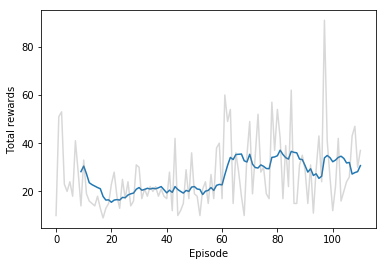

In [49]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

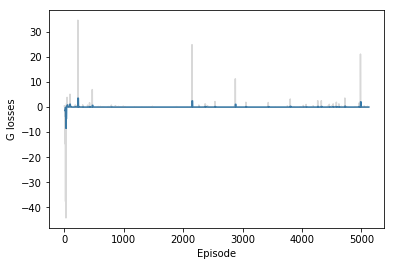

In [53]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

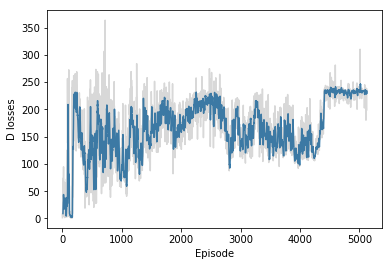

In [54]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses R')

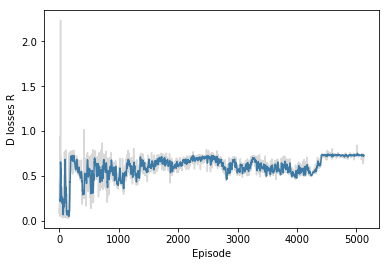

In [58]:
eps, arr = np.array(d_lossQsigm_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses Q')

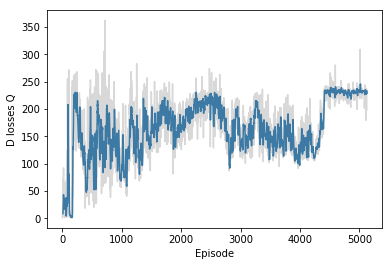

In [59]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

## Testing

Let's checkout how our trained agent plays the game.

In [ ]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model-seq.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(11):
        state = env.reset()
        total_reward = 0
        g_initial_state = sess.run(model.g_initial_state)
        d_initial_state = sess.run(model.d_initial_state)

        # Training steps/batches
        while True:
            # Testing/inference
            env.render()
            action_logits, g_initial_state, d_initial_state = sess.run(
                fetches=[model.actions_logits, model.g_final_state, model.d_final_state], 
                feed_dict={model.states: np.reshape(state, [1, -1]),
                           model.g_initial_state: g_initial_state, 
                           model.d_initial_state: d_initial_state})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
                
# Closing the env
print('total_reward: {}'.format(total_reward))
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.